In [2]:
%matplotlib inline
import os
import json
from glob import glob

import matplotlib.pyplot as plt
import seaborn
import yaml

BASE_DIR = os.path.realpath(os.path.join(os.getcwd(), '..'))

with open(os.path.join(BASE_DIR, "config.yml")) as f:
    config = yaml.load(f)
    
seaborn.set_context('paper')
seaborn.set_style("whitegrid")

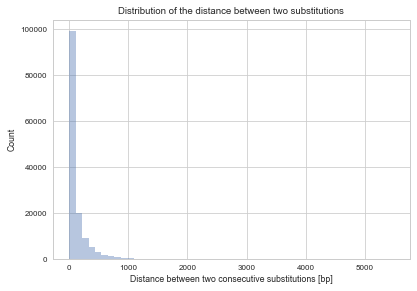

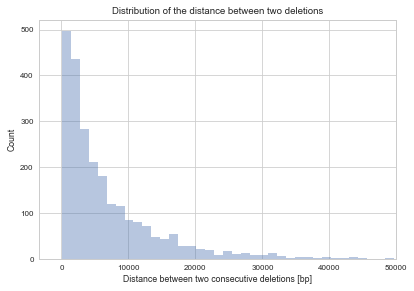

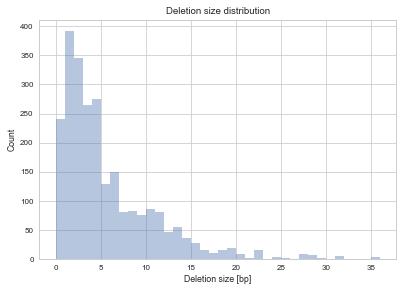

In [3]:
genome_mutations = glob(os.path.join(BASE_DIR, "genomes/**/*_mutations.json"), recursive=True)
genome_mutations

subst_distances = []
del_distances = []
del_sizes = []

for mut_file in genome_mutations:
    with open(mut_file) as f:
        mutations = json.load(f)
        
        for chr_mut in mutations:
            last_subst = -1
            last_del = -1
            for mut in chr_mut:
                if mut['mut_type'] == "MutationType.SUBSTITUTION":
                    if last_subst != -1:
                        dist = mut['haplo_pos'] - last_subst
                        subst_distances.append(dist)
                        
                    last_subst = mut['haplo_pos']
                else:
                    if last_del != -1:
                        dist = mut['haplo_pos'] - last_del
                        del_distances.append(dist)
                    
                    last_del = mut['haplo_pos']
                    del_sizes.append(-mut['size'])
                    
plt.figure()
#plt.hist(subst_distances, bins=100)
seaborn.distplot(subst_distances, kde=False)
plt.xlabel('Distance between two consecutive substitutions [bp]')
plt.ylabel('Count')
#plt.xlim(xmax=2000)
plt.title('Distribution of the distance between two substitutions')
plt.savefig(os.path.join(BASE_DIR, 'figures', 'subst-dist.png'), dpi=256, transparent=True)

plt.figure()
#plt.hist(del_distances, bins=100)
seaborn.distplot(del_distances, kde=False)
plt.xlabel('Distance between two consecutive deletions [bp]')
plt.ylabel('Count')
plt.title('Distribution of the distance between two deletions')
plt.xlim(xmax=50000)
plt.savefig(os.path.join(BASE_DIR, 'figures', 'del-dist.png'), dpi=256, transparent=True)

plt.figure()
bin_size = 1
bins = range(0, max(del_sizes)+bin_size, bin_size)
seaborn.distplot(del_sizes, kde=False, bins=bins)
plt.xlabel('Deletion size [bp]')
plt.ylabel('Count')
plt.title('Deletion size distribution')
plt.savefig(os.path.join(BASE_DIR, 'figures', 'deletion-size-dist.png'), dpi=256, transparent=True)